In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('GC=F.csv')

In [3]:
df = df[['Date', 'Adj Close']]
df = df.set_index('Date')


#### Daily Return = (df[t] / df[t-1]) - 1

In [4]:
df['dr']= (df/ df.shift(1)) -1
df['log'] = np.log(df['Adj Close'].shift(-1)) - np.log(df['Adj Close'])

In [5]:
df.iloc[0,1] = 0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5412 entries, 2000-08-30 to 2022-03-25
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5412 non-null   float64
 1   dr         5412 non-null   float64
 2   log        5411 non-null   float64
dtypes: float64(3)
memory usage: 169.1+ KB


In [7]:
df = df.loc['2018-01-01' : '2022-01-01', :]

In [8]:
df = df.rename(columns={'Adj Close' : 'close'})

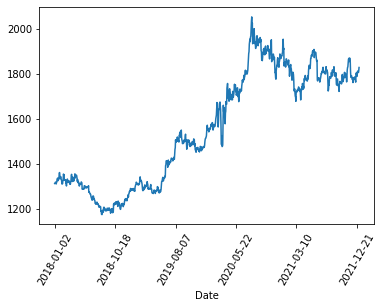

In [9]:
df.close.plot()
plt.xticks(rotation= 60);

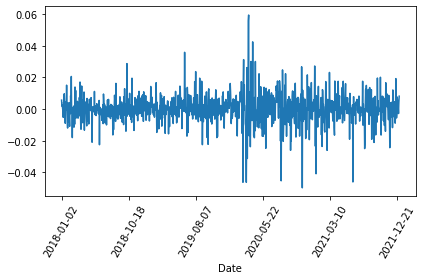

In [11]:
# Daily Return
df.dr.plot()
plt.xticks(rotation=60)
plt.tight_layout();

### We need to test if the mean of OIL Daily Return = 0 or not
our HT will be:
$$H0: mean = 0$$
$$H1: mean <> 0$$

1- I am going to use the equation of zscore
$$Z = (x-μ)/σ$$

Z	=	standard score<br>
x	=	observed value<br>
μ	=	mean of the sample<br>
σ	=	standard deviation of the sample


In [10]:
mean = df.dr.mean()
std = df.dr.std(ddof=1)
n = df.shape[0]
zscore = (mean - 0) / (std/np.sqrt(n))
zscore

1.2552447608460489

### confidence level using scipy.stats model

In [11]:

alpha = 0.05

zleft = norm.ppf(alpha/2, 0, 1)
zright = -zleft  # z-distribution is symmetric 
print(zleft, zright)

-1.9599639845400545 1.9599639845400545


### Calculating Zscore using Center Limit Theorm and Simulating from Null Hypothesis (Mean = 0)

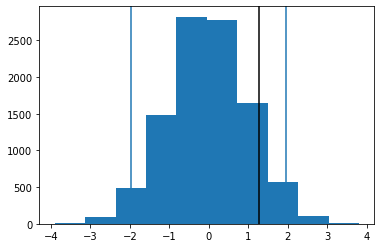

In [12]:
null_vals = np.random.normal(0,1, 10000)
plt.hist(null_vals)
plt.axvline(zright)
plt.axvline(zleft)
plt.axvline(zscore, c='black');

## P-Value to decide if we will reject the Null or Fail to reject it.

In [13]:
print('At significant level of {}, shall we reject: {}'.format(alpha, zscore>zright or zscore<zleft))

At significant level of 0.05, shall we reject: False


### Calculating Zscore using Center Limit Theorm - BOOT STRAPING - and Simulating from Null Hypothesis (Mean = 0)

In [14]:
means = []
for _ in range(10000):
    sample = df.dr.sample(df.shape[0], replace=True)
    means.append(sample.mean())

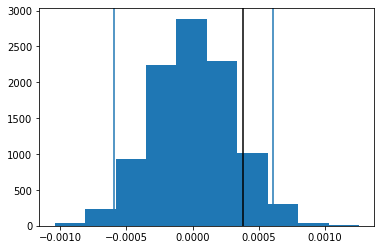

In [15]:
null_vals = np.random.normal(0, np.std(means), 10000)
plt.hist(null_vals)
plt.axvline(np.percentile(null_vals, 2.5))
plt.axvline(np.percentile(null_vals, 97.5))
plt.axvline(mean, c='black');

## P-Value to decide if we will reject the Null or Fail to reject it
at segnificance level of 0.05 , 95% CI

In [16]:
(null_vals > mean).mean()

0.1102

Pvalue > 0.05, so we Fail to reject the Null

### Calculating CI using statsmodels.api model based on mean

In [17]:
sm.stats.DescrStatsW(df.dr).zconfint_mean()

(-0.00021284325067264323, 0.0009710753700912705)

### Calculating CI using Numpy based on mean

In [18]:
np.percentile(means, 2.5), np.percentile(means, 97.5)

(-0.0002231248716926537, 0.0009696291335637951)

### Calculating CI using scipy.stats based on ZScore

In [19]:
# step 3
alpha = 0.05

zright = norm.ppf(1-alpha, 0, 1)
zleft = -zright
print(zleft,zright)

-1.6448536269514722 1.6448536269514722


### Calculating PValue

In [20]:
# step 4
print('At significant level of {}, shall we reject: {}'.format(alpha, zscore>zright))

At significant level of 0.05, shall we reject: False


### Calculating PValue using scipy.stats

In [21]:
# step 3 (p-value)
p = 1 - norm.cdf(zscore, 0, 1)
print(p)

0.10469496055371197


In [22]:
# step 4
print('At significant level of {}, shall we reject: {}'.format(alpha, p < alpha))

At significant level of 0.05, shall we reject: False


### We have 95% Confedince that the mean of Daily Return of OIL between '2018-01-01' : '2022-01-01' = 0